# Final Project

## Course: Programming for Data Science

## IDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Formatting options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress = True, linewidth = 120, edgeitems = 5)
sns.set_theme(style="whitegrid")



In [2]:
# 1. Load data and view structure

dataPath = "../Data/Raw/parsed_books_data.tsv"

df = pd.read_csv(dataPath, sep = "\t", na_values = ["NA"])

sampleCount, featureCount = df.shape

print(f"Total samples:    {sampleCount}")
print(f"Total features:   {featureCount}")
print("-" * 30)
print("Columns:", df.columns.tolist())

print("-" * 30)
display(df.head())


Total samples:    5283
Total features:   24
------------------------------
Columns: ['price', 'title', 'rating', 'num_ratings', 'num_reviews', 'num_pages', 'genres', 'publication_year', 'author', 'author_book_count', 'author_followers_count', 'five_star_count', 'five_star_percentage', 'four_star_count', 'four_star_percentage', 'three_star_count', 'three_star_percentage', 'two_star_count', 'two_star_percentage', 'one_star_count', 'one_star_percentage', 'votes', 'category', 'award_year']
------------------------------


,price,title,rating,num_ratings,num_reviews,num_pages,genres,publication_year,author,author_book_count,author_followers_count,five_star_count,five_star_percentage,four_star_count,four_star_percentage,three_star_count,three_star_percentage,two_star_count,two_star_percentage,one_star_count,one_star_percentage,votes,category,award_year
0,14.99,The Wedding People,4.16,327019,38667,384.0,Fiction|Romance|Audiobook|Contemporary|Literar...,2024,Alison Espach,8,2416.0,123227,37,144585,44,48565,14,8388,2,2254,0,94733,Fiction,2024
1,14.99,Intermezzo,3.93,171506,31312,454.0,Fiction|Contemporary|Literary Fiction|Romance|...,2024,Sally Rooney,43,61500.0,53605,31,68660,40,36424,21,9842,5,2975,1,67268,Fiction,2024
2,9.13,Welcome to the Hyunam-Dong Bookshop,3.97,49745,9574,307.0,Contemporary|Books About Books|Audiobook|Cozy|...,2022,Hwang Bo-Reum,3,740.0,15568,31,20267,40,11063,22,2367,4,480,0,51958,Fiction,2024
3,13.99,Blue Sisters,3.98,140226,19902,342.0,Fiction|Contemporary|Literary Fiction|Audioboo...,2024,Coco Mellors,5,5253.0,43785,31,60355,43,27337,19,7508,5,1241,0,50659,Fiction,2024
4,14.99,Here One Moment,4.05,146803,16125,512.0,Fiction|Audiobook|Mystery|Contemporary|Thrille...,2024,Liane Moriarty,42,71800.0,49893,33,62470,42,27770,18,5392,3,1278,0,48432,Fiction,2024


In [3]:
# 2. Data integrity

zeroPriceCount = (df['price'] == 0).sum()
naPriceCount = df['price'].isna().sum()

print(f"Duplicated rows: {df.duplicated().sum()}")
print("Missing values per column:")
print("-" * 30)
missingInfo = df.isna().sum()
print(missingInfo[missingInfo > 0])
print("-" * 30)
print(f"Books with price 0:       {zeroPriceCount}")
print(f"Books with price 'NA':    {naPriceCount}")

Duplicated rows: 0
Missing values per column:
------------------------------
price                     2031
num_pages                   16
author_followers_count       5
dtype: int64
------------------------------
Books with price 0:       438
Books with price 'NA':    2031


In [4]:
# ==========================================
# 3. FEATURE CLASSIFICATION (Refined)
# ==========================================

# Configuration
DISCRETE_THRESHOLD = 25 
TARGET_COL = ''

# Columns to explicitly ignore/drop:
COLS_TO_IGNORE = [
    # 'is_audiobook', 'author', 'title', 'category', 'award_year',
    # 'votes', 'num_reviews',
    # 'five_star_count', 'five_star_percentage',
    # 'four_star_count', 'four_star_percentage',
    # 'three_star_count', 'three_star_percentage',
    # 'two_star_count', 'two_star_percentage',
    # 'one_star_count', 'one_star_percentage', 
]

COLS_TO_AVOID = ['genres_list', 'binned']

col_info = {}
target_features = []
categorical_features = [] 
numerical_discrete_features = []
numerical_continuous_features = []
ignored_features = [] 

# Loop through columns to detect type
for col_name in df.columns:
    if col_name in COLS_TO_AVOID:
        continue

    unique_count = df[col_name].nunique()
    
    if col_name in COLS_TO_IGNORE:
        col_type = "Ignored"
        ignored_features.append(col_name)

    elif col_name == TARGET_COL:
        col_type = "Target"
        target_features.append(col_name)
    
    elif pd.api.types.is_numeric_dtype(df[col_name]):
        col_type = "Numerical"
        if unique_count < DISCRETE_THRESHOLD:
            numerical_discrete_features.append(col_name)
        else:
            numerical_continuous_features.append(col_name)
            
    else:
        col_type = "Categorical"
        categorical_features.append(col_name)

    col_info[col_name] = {"Type": col_type, "UniqueCount": unique_count}

print("-" * 60)
print(f"{'Column Name':<30} | {'Type':<12} | {'Unique Vals'}")
print("-" * 60)

# Group 1: Categorical
for col in categorical_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

# Group 2: Numerical 
for col in numerical_discrete_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

for col in numerical_continuous_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

# Group 3: Ignored
for col in ignored_features:
    if col in col_info:
        info = col_info[col]
        print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

print("\nSummary:")
print(f"Categorical Features:   {len(categorical_features)}")
print(f"Numerical Discrete:     {len(numerical_discrete_features)}")
print(f"Numerical Continuous:   {len(numerical_continuous_features)}")
print(f"Ignored Features:       {len(ignored_features)}")

------------------------------------------------------------
Column Name                    | Type         | Unique Vals
------------------------------------------------------------
title                          | Categorical  | 5036
genres                         | Categorical  | 4724
author                         | Categorical  | 3106
category                       | Categorical  | 31
------------------------------------------------------------
publication_year               | Numerical    | 23
two_star_percentage            | Numerical    | 22
one_star_percentage            | Numerical    | 13
award_year                     | Numerical    | 14
price                          | Numerical    | 140
rating                         | Numerical    | 155
num_ratings                    | Numerical    | 4956
num_reviews                    | Numerical    | 3952
num_pages                      | Numerical    | 668
author_book_count              | Numerical    | 343
author_followers_count       

In [5]:
# 4. Quartiles and statistics
print(df.describe().map(lambda x: f"{x:.2f}"))

         price   rating num_ratings num_reviews num_pages publication_year author_book_count author_followers_count five_star_count five_star_percentage four_star_count four_star_percentage three_star_count three_star_percentage two_star_count two_star_percentage one_star_count one_star_percentage      votes award_year
count  3252.00  5283.00     5283.00     5283.00   5267.00          5283.00           5283.00                5278.00         5283.00              5283.00         5283.00              5283.00          5283.00               5283.00        5283.00             5283.00        5283.00             5283.00    5283.00    5283.00
mean      9.62     4.04   106418.65     9836.15    342.75          2017.04             93.18               27791.74        44009.22                36.87        37778.93                36.57         18294.97                 18.70        4591.78                4.20        1743.74                1.15   10358.62    2017.15
std       5.00     0.26   307798.65  

Number of genres: 456


,0
3199,Fiction
3003,Audiobook
1620,Nonfiction
1544,Fantasy
1312,Romance
1172,Contemporary
1050,Young Adult
1013,Adult
863,Mystery


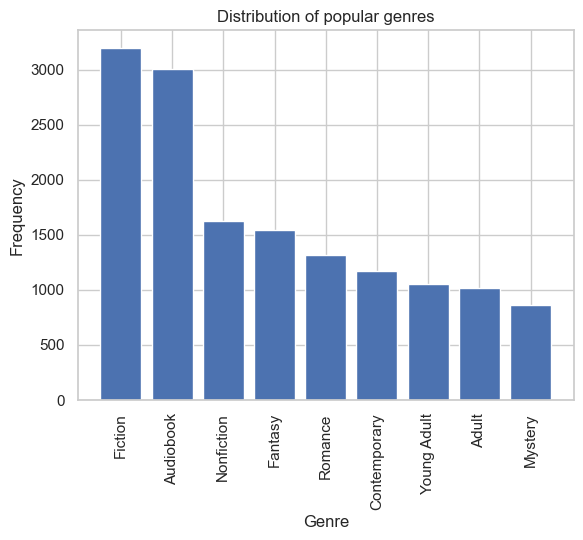

In [6]:
# 5. Genre Analysis
genres = df["genres"].str.split("|").values
genres = np.hstack(genres)
genres, frequency = np.unique(genres, return_counts=True)

print("Number of genres:", genres.size)

popular_genres = frequency.argsort()[:-10:-1]

popular_genres_df = pd.DataFrame(genres[popular_genres],
                                 frequency[popular_genres])

display(popular_genres_df)

fig, axes = plt.subplots()
axes.bar(genres[popular_genres], frequency[popular_genres])
axes.set_title("Distribution of popular genres")
axes.set_xlabel("Genre")
axes.set_ylabel("Frequency")
axes.tick_params(axis='x', rotation=90)
plt.show()


--- Numerical Feature Distributions and Outliers (20 features) ---


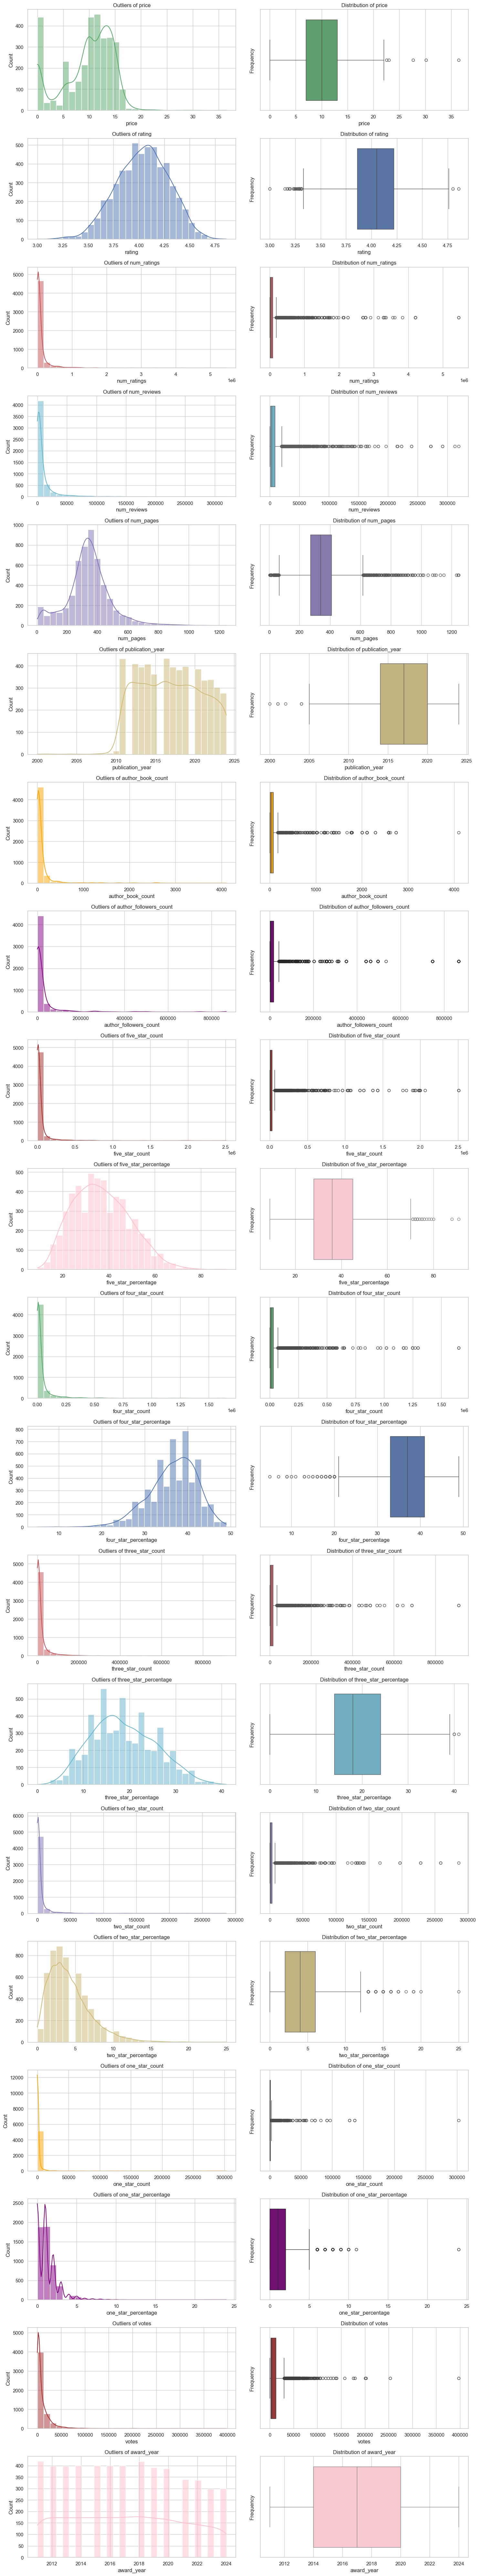

In [7]:
# ==========================================
# 6. NUMERICAL FEATURE DISTRIBUTIONS & OUTLIERS
# ==========================================

# 1. Identify numerical features
df_columns = df.columns
categorical_features = ['title', 'genres', 'category', 'author']
numerical_features = [col for col in df_columns if col not in categorical_features]

num_features = len(numerical_features)
colors = ['g', 'b', 'r', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']

# 2. Create subplots: 1 row per feature, 2 columns (Boxplot | Histogram)
print(f"\n--- Numerical Feature Distributions and Outliers ({num_features} features) ---")
fig, axes = plt.subplots(num_features, 2, figsize=(15, 4 * num_features))

for idx, col in enumerate(numerical_features):
    # Select color for this row
    current_color = colors[idx % len(colors)]
    
    # Left Side: Box Plot (Outlier Visualization)
    sns.boxplot(x=df[col], color=current_color, ax=axes[idx, 1])
    axes[idx, 0].set_title(f'Outliers of {col}', fontsize=12)
    axes[idx, 0].set_xlabel('')
    
    # Right Side: Histogram (Distribution Visualization)
    sns.histplot(df[col], bins=30, kde=True, color=current_color, ax=axes[idx, 0])
    axes[idx, 1].set_title(f'Distribution of {col}', fontsize=12)
    axes[idx, 1].set_xlabel(col)
    axes[idx, 1].set_ylabel('Frequency')

# 3. Final polish
plt.tight_layout()
plt.show()

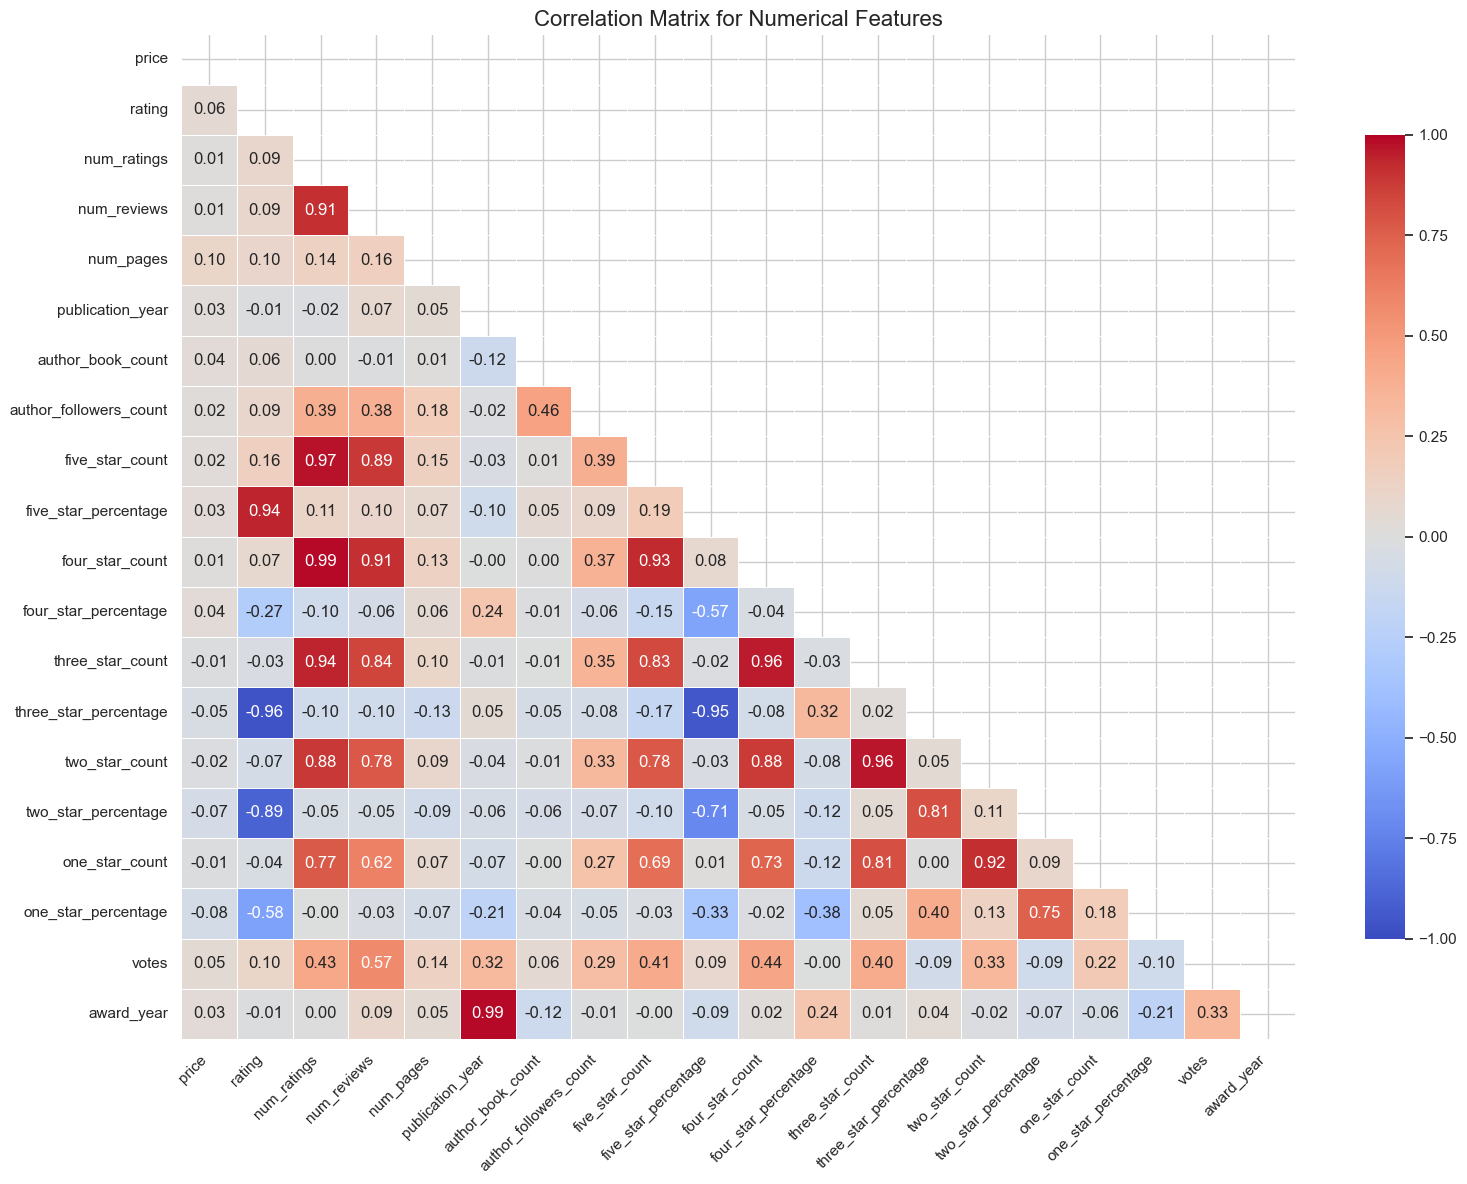

In [8]:
# 6.3 Correlation Matrix
categorical_features = ['title', 'genres', 'category', 'author']
numerical_features = [col for col in df_columns if col not in categorical_features]

features_for_corr = numerical_features

plt.figure(figsize=(16, 12))

# 1. Calculate Correlation
corr = df[features_for_corr].corr()

# 2. Create Mask for Upper Triangle
# np.triu returns the upper triangle, which we want to hide (True)
mask = np.triu(np.ones_like(corr, dtype=bool))

# 3. Plot Heatmap
sns.heatmap(
    corr, 
    mask=mask,          # Hide upper triangle
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1,            # Fix scale range -1 to 1
    vmax=1, 
    linewidths=0.5,     # Add grid lines
    cbar_kws={"shrink": 0.8} # Adjust colorbar size
)

plt.title('Correlation Matrix for Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Question 1: How does the pricing of a book affect it's reach? Do books available via subscription services and bundles achieve higher visibility, and does a higher price leads to lower engagement?

In [9]:
df_nonna = df[(df["price"] != 0) & ~(df["price"].isna())]

In [10]:
df_nonna["price"].describe()

count    2814.000000
mean       11.113088
std         3.504282
min         0.990000
25%         8.990000
50%        11.990000
75%        13.990000
max        36.480000
Name: price, dtype: float64

In [11]:
df_nonna["price"].value_counts()

price
9.99     431
12.99    331
11.99    329
13.99    320
14.99    313
        ... 
10.81      1
9.71       1
9.65       1
9.62       1
8.07       1
Name: count, Length: 139, dtype: int64

In [12]:
df.loc[df["price"] == 0, "price"] = -1
df.loc[df["price"].isna(), "price"] = -2

In [13]:
bins = [-3, -2, 0, 9, 12, 14, 36]
df["binned"] = pd.cut(df["price"], bins)

In [14]:
df["binned"].unique()

[(14.0, 36.0], (9.0, 12.0], (12.0, 14.0], (-3.0, -2.0], (-2.0, 0.0], (0.0, 9.0], NaN]
Categories (6, interval[int64, right]): [(-3, -2] < (-2, 0] < (0, 9] < (9, 12] < (12, 14] < (14, 36]]

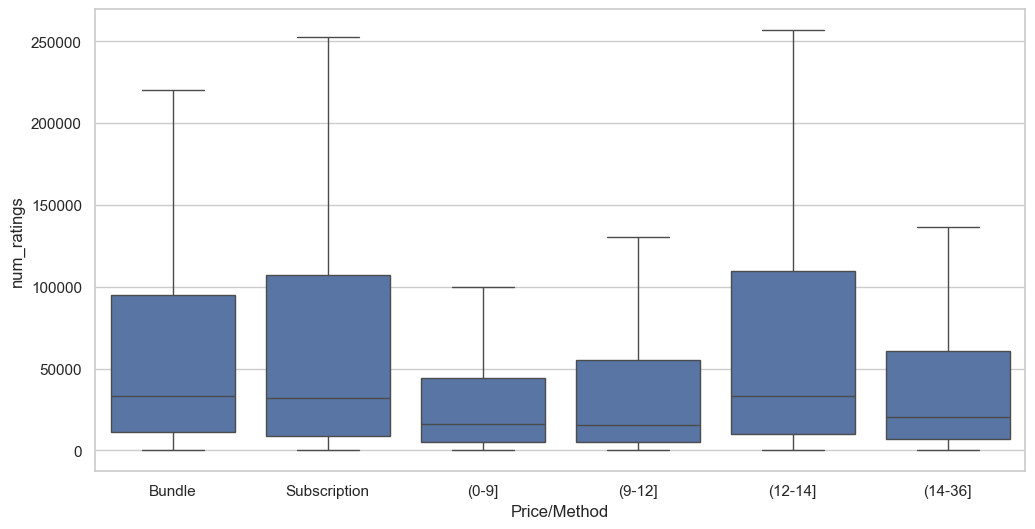

In [15]:
plt.figure(figsize=(12, 6))

ax = sns.boxplot(
    x=df["binned"], 
    y=df["num_ratings"], 
    data=df.groupby("binned", observed=True)["num_ratings"].apply(pd.DataFrame),
    showfliers=False
)
ax.set_xticks(range(6))
ax.set_xticklabels(["Bundle", "Subscription", "(0-9]", "(9-12]", "(12-14]", "(14-36]"])
ax.set_xlabel("Price/Method")

plt.show()

In [16]:
df_na = df[df["price"] == -2]
df_0 = df[df["price"] == -1]

In [17]:
df_na["num_ratings"].describe()

count    2.031000e+03
mean     1.230330e+05
std      3.304099e+05
min      3.600000e+01
25%      1.121650e+04
50%      3.337100e+04
75%      9.505000e+04
max      4.204761e+06
Name: num_ratings, dtype: float64

In [18]:
df_0["num_ratings"].describe()

count    4.380000e+02
mean     1.232800e+05
std      2.728595e+05
min      1.000000e+01
25%      8.888500e+03
50%      3.196150e+04
75%      1.068905e+05
max      2.771997e+06
Name: num_ratings, dtype: float64

In [19]:
df_nonna["num_ratings"].describe()

count    2.814000e+03
mean     9.180281e+04
std      2.951066e+05
min      3.800000e+01
25%      6.447250e+03
50%      1.941950e+04
75%      6.328875e+04
max      5.464757e+06
Name: num_ratings, dtype: float64

In [20]:
df_na["author"].unique().size

988

In [21]:
df_nonna[(df_nonna["price"] > 12) & (df_nonna["price"] <= 14)]["num_ratings"].describe()

count    6.730000e+02
mean     1.434806e+05
std      3.777773e+05
min      2.980000e+02
25%      9.667000e+03
50%      3.312800e+04
75%      1.096120e+05
max      3.358904e+06
Name: num_ratings, dtype: float64

In [36]:
from scipy import stats

# Define the groups for Distribution Model Validation
# Note: Based on your friend's mapping: NA (-2) = Bundle, 0 (-1) = Subscription
group_bundle = df[df["price"] == -2]["num_ratings"]
group_sub = df[df["price"] == -1]["num_ratings"]
group_traditional = df[df["price"] > 0]["num_ratings"]

# Define groups for Price Point Validation (Within traditional only)
# We want to test if (12, 14] is really better than the others
group_12_14 = df[(df["price"] > 12) & (df["price"] <= 14)]["num_ratings"]
group_rest_trad = df[(df["price"] > 0) & ((df["price"] <= 12) | (df["price"] > 14))]["num_ratings"]

In [37]:
# --- VALIDATION 1: Distribution Models ---
print("=== Validation 1: Distribution Models ===")
h_stat1, p_val1 = stats.kruskal(group_bundle, group_sub, group_traditional)
print(f"Kruskal-Wallis p-value: {p_val1:.4e}")

# Pairwise check: Is Subscription reach significantly different from Traditional?
u_stat1, p_val_u1 = stats.mannwhitneyu(group_sub, group_traditional, alternative='greater')
print(f"Subscription vs. Traditional p-value: {p_val_u1:.4e}")

# --- VALIDATION 2: The $12-$14 Sweet Spot ---
print("\n=== Validation 2: The $12-$14 'Sweet Spot' ===")
u_stat2, p_val_u2 = stats.mannwhitneyu(group_12_14, group_rest_trad, alternative='greater')
print(f"Is $12-$14 significantly higher than other price points? p-value: {p_val_u2:.4e}")

# --- RESULTS ANALYSIS ---
if p_val_u1 < 0.05:
    print("\nInsight 1: Subscription models drive significantly higher publicity than retail.")
if p_val_u2 < 0.05:
    print("Insight 2: The $12-$14 range is statistically the most effective retail price point.")

=== Validation 1: Distribution Models ===
Kruskal-Wallis p-value: 7.3805e-25
Subscription vs. Traditional p-value: 2.1674e-07

=== Validation 2: The $12-$14 'Sweet Spot' ===
Is $12-$14 significantly higher than other price points? p-value: 8.2755e-19

Insight 1: Subscription models drive significantly higher publicity than retail.
Insight 2: The $12-$14 range is statistically the most effective retail price point.


The substantially higher mean of ratings for subscription books suggests they may represent a more appealing market

## Question 2: How does an author's reputation drive the reach and reception of a book? Does a wider audience lead to lower average ratings because of broader scrutiny?

In [22]:
print("Value counts:")
print(df["author_followers_count"].value_counts())

print("\n\n")

print("Describe:")
print(df['author_followers_count'].describe())

Value counts:
author_followers_count
10800.0     23
259000.0    21
868000.0    20
14500.0     19
122000.0    19
            ..
833.0        1
196.0        1
655.0        1
1280.0       1
1480.0       1
Name: count, Length: 2085, dtype: int64



Describe:
count      5278.000000
mean      27791.738916
std       87762.918476
min           2.000000
25%         691.250000
50%        3589.500000
75%       16700.000000
max      868000.000000
Name: author_followers_count, dtype: float64


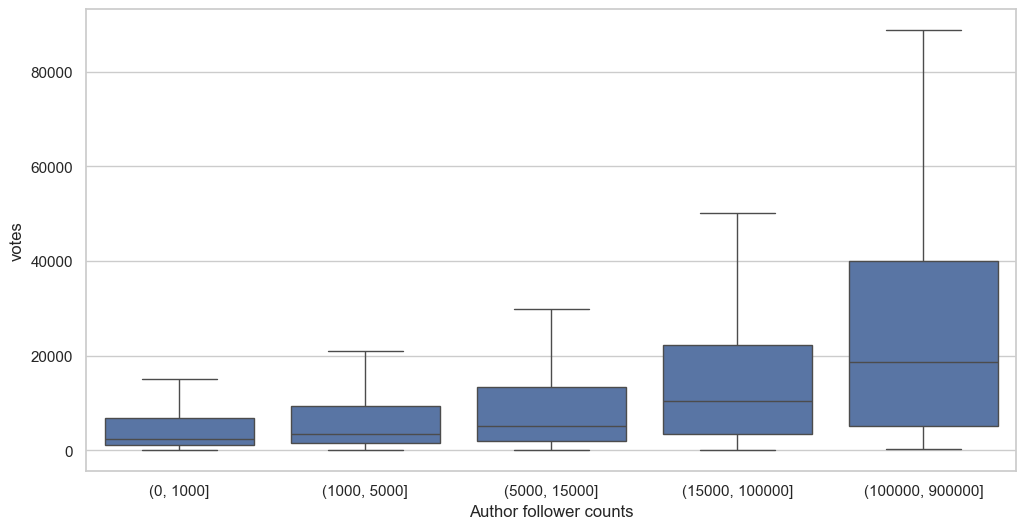

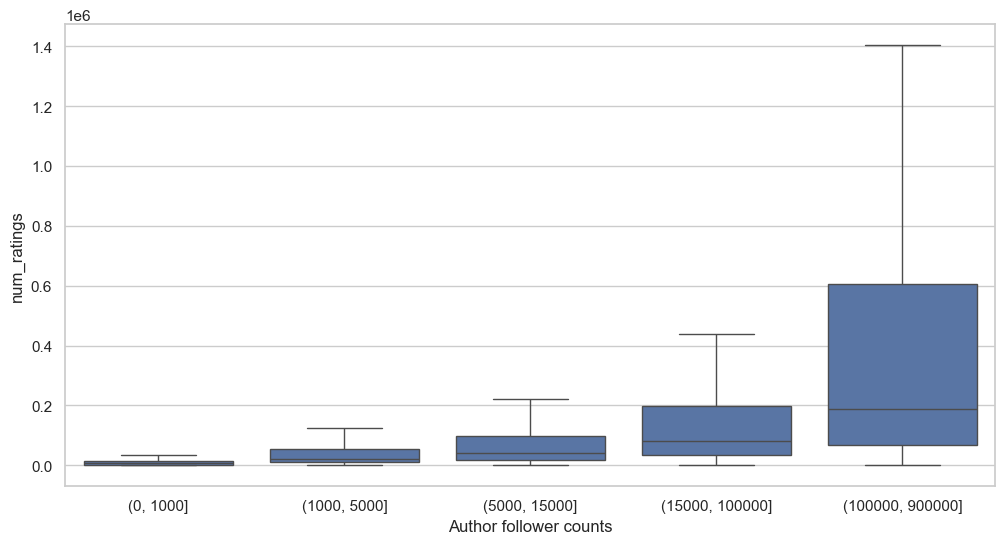

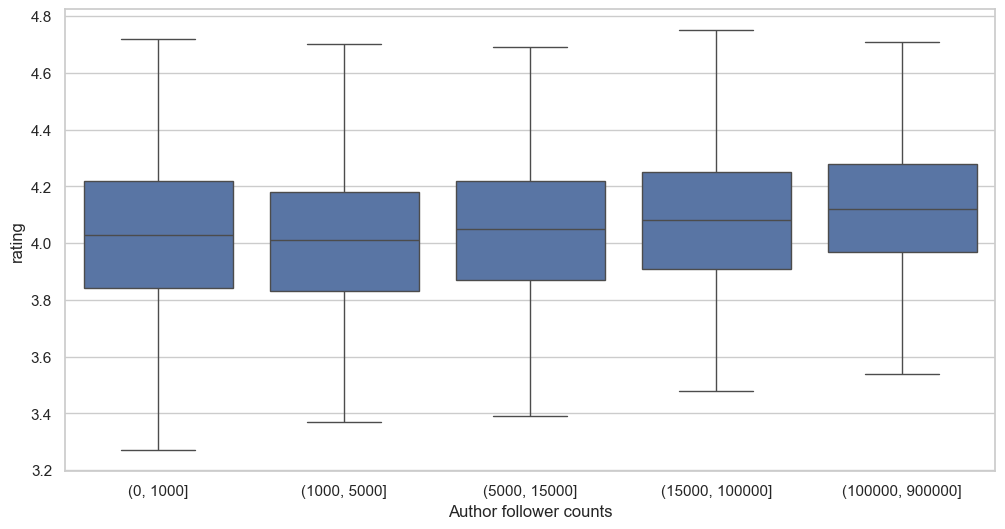

In [23]:
bins = [0, 1000, 5000, 15000, 100000, 900000]
df["binned"] = pd.cut(df["author_followers_count"], bins)
for column in ["votes", "num_ratings", "rating"]:
    plt.figure(figsize=(12, 6))

    sns.boxplot(
        x=df["binned"], 
        y=df[column], 
        data=df.groupby("binned", observed=True)[column].apply(pd.DataFrame), 
        # palette="viridis", 
        showfliers=False
    ).set(
        xlabel = "Author follower counts",
    )

    plt.show()

In [38]:
from scipy import stats

# 1. Prepare the binned groups for num_ratings
# We use the same bins your friend defined
bins = [0, 1000, 5000, 15000, 100000, 900000]
df["author_tier"] = pd.cut(df["author_followers_count"], bins)

# Create a list of arrays (one for each tier)
tiers = df["author_tier"].unique().sort_values()
reach_groups = [df[df["author_tier"] == tier]["num_ratings"].dropna() for tier in tiers]

print("=== Validation 1: Reputation vs. Reach (Volume) ===")
# Kruskal-Wallis test: Are the medians of these 5 groups different?
h_stat, p_val_h = stats.kruskal(*reach_groups)
print(f"Kruskal-Wallis p-value: {p_val_h:.4e}")

# Trend Test: Spearman Correlation (Reputation vs. Reach)
# This tests if more followers = more ratings consistently
corr_reach, p_reach = stats.spearmanr(df['author_followers_count'], df['num_ratings'], nan_policy='omit')
print(f"Spearman Correlation (Followers vs. Reach): {corr_reach:.4f} (p: {p_reach:.4e})")

=== Validation 1: Reputation vs. Reach (Volume) ===
Kruskal-Wallis p-value: nan
Spearman Correlation (Followers vs. Reach): 0.6839 (p: 0.0000e+00)


/var/folders/k_/fd82nfhs1dsb_t7rjjq_wcd40000gn/T/ipykernel_4755/3457506185.py:14: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_stat, p_val_h = stats.kruskal(*reach_groups)


In [39]:
print("\n=== Validation 2: The 'Quality Floor' Effect ===")

# Group A: Emerging Authors (Lowest Tier)
group_low = df[df["author_followers_count"] <= 1000]["rating"].dropna()
# Group B: Superstar Authors (Highest Tier)
group_high = df[df["author_followers_count"] >= 100000]["rating"].dropna()

# 1. Compare Means
t_stat, p_val_t = stats.ttest_ind(group_high, group_low, equal_var=False)
print(f"Mean Rating Comparison (Superstar vs. Emerging) p-value: {p_val_t:.4e}")

# 2. Compare the "Floor" (25th Percentile)
print(f"25th Percentile Rating - Emerging:  {group_low.quantile(0.25):.2f}")
print(f"25th Percentile Rating - Superstar: {group_high.quantile(0.25):.2f}")

# 3. Reception Correlation
corr_qual, p_qual = stats.spearmanr(df['author_followers_count'], df['rating'], nan_policy='omit')
print(f"Spearman Correlation (Followers vs. Rating Value): {corr_qual:.4f}")


=== Validation 2: The 'Quality Floor' Effect ===
Mean Rating Comparison (Superstar vs. Emerging) p-value: 8.4900e-12
25th Percentile Rating - Emerging:  3.84
25th Percentile Rating - Superstar: 3.97
Spearman Correlation (Followers vs. Rating Value): 0.0908


*   The median lines increase as the author's follower count rises, indicating that a larger audience positively impacts the book's performance.

## Question 3: How do genres affect num rating, which genres or combinations of genres do readers want?

### 1. Audiobook

Average Page Count per Year:
award_year
2011    335.758950
2012    336.469849
2013    349.834171
2014    337.496222
2015    336.751880
2016    333.640000
2017    336.433584
2018    338.129187
2019    336.063939
2020    329.135417
2021    344.864307
2022    344.657738
2023    391.705686
2024    366.989655
Name: mean, dtype: float64
    award_year   num_pages
0         2011  335.758950
1         2012  336.469849
2         2013  349.834171
3         2014  337.496222
4         2015  336.751880
5         2016  333.640000
6         2017  336.433584
7         2018  338.129187
8         2019  336.063939
9         2020  329.135417
10        2021  344.864307
11        2022  344.657738
12        2023  391.705686
13        2024  366.989655


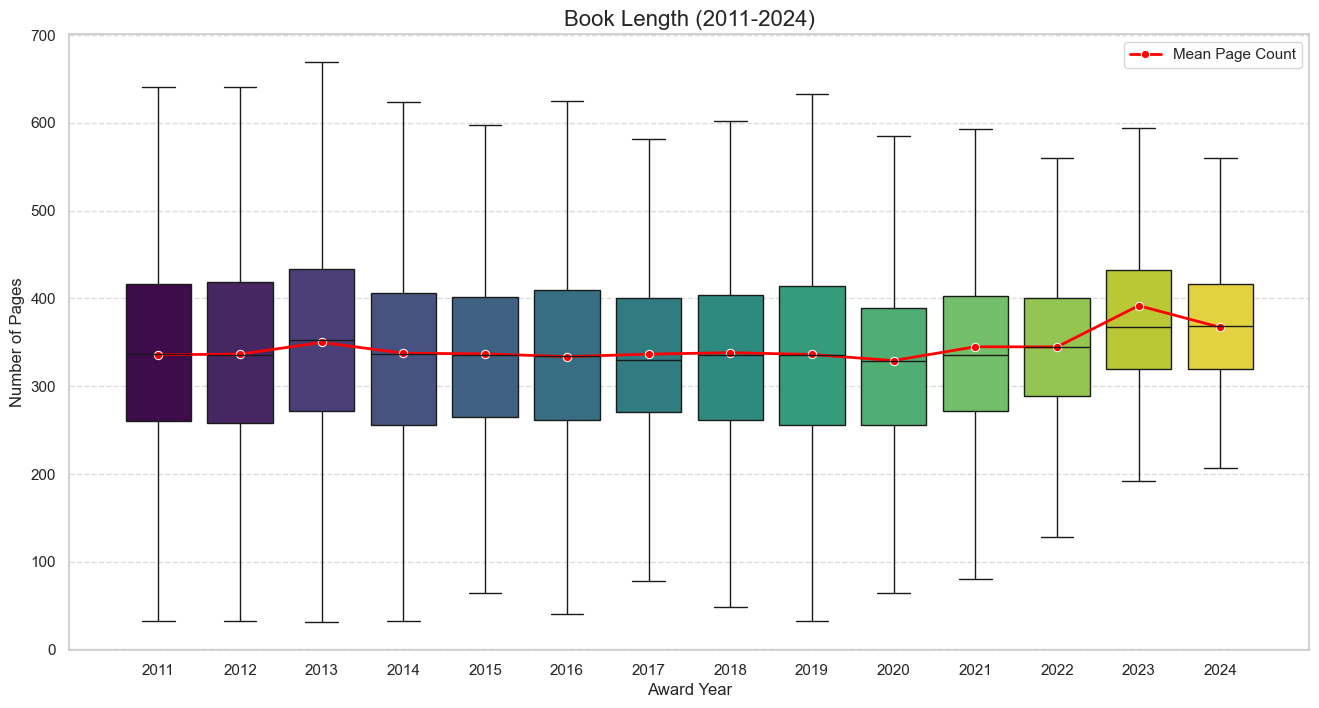

In [24]:
# ==========================================
# QUESTION 3: Reading Habits - Page Count Trends
# ==========================================

# 1. Prepare Data
# Drop rows where pages are missing (only 16 rows based on your EDA)
pages_df = df.dropna(subset=['num_pages']).copy()

# Ensure integer type
pages_df['num_pages'] = pages_df['num_pages'].astype(int)

# 2. Statistical Summary by Year
# This calculates Q1, Median, Q3, Mean, etc. for each year
yearly_stats = pages_df.groupby('award_year')['num_pages'].describe()
print("Average Page Count per Year:")
print(yearly_stats['mean'])

# 3. Visualization: Box Plot
plt.figure(figsize=(16, 8))

# A. The Box Plot (Distribution)
sns.boxplot(
    x='award_year', 
    y='num_pages', 
    data=pages_df, 
    palette="viridis", 
    hue='award_year',
    showfliers=False,
    legend=False
)

# B. Overlay the Mean Trend (Line Plot)
# Group by year and get mean to draw a trend line
mean_trend = pages_df.groupby('award_year')['num_pages'].mean().reset_index()
print(mean_trend)
sns.lineplot(
    x=range(len(mean_trend)), # Align with categorical x-axis of boxplot
    y='num_pages', 
    data=mean_trend, 
    color='red', 
    marker='o', 
    label='Mean Page Count',
    linewidth=2
)

plt.title('Book Length (2011-2024)', fontsize=16)
plt.xlabel('Award Year', fontsize=12)
plt.ylabel('Number of Pages', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


=== Yearly Trends Data: Pages vs Audiobooks ===
    award_year  num_pages  is_audiobook  audio_pct
0         2011      335.8      0.295943       29.6
1         2012      336.5      0.336683       33.7
2         2013      349.8      0.412060       41.2
3         2014      337.5      0.446115       44.6
4         2015      336.8      0.483709       48.4
5         2016      333.6      0.530000       53.0
6         2017      336.4      0.634085       63.4
7         2018      338.1      0.672249       67.2
8         2019      336.1      0.626598       62.7
9         2020      329.1      0.669251       66.9
10        2021      344.9      0.707965       70.8
11        2022      344.7      0.697329       69.7
12        2023      391.7      0.812709       81.3
13        2024      367.0      0.806667       80.7
--------------------------------------------------
Correlation (Pearson) between Page Count and Audiobook %: 0.5395
--------------------------------------------------


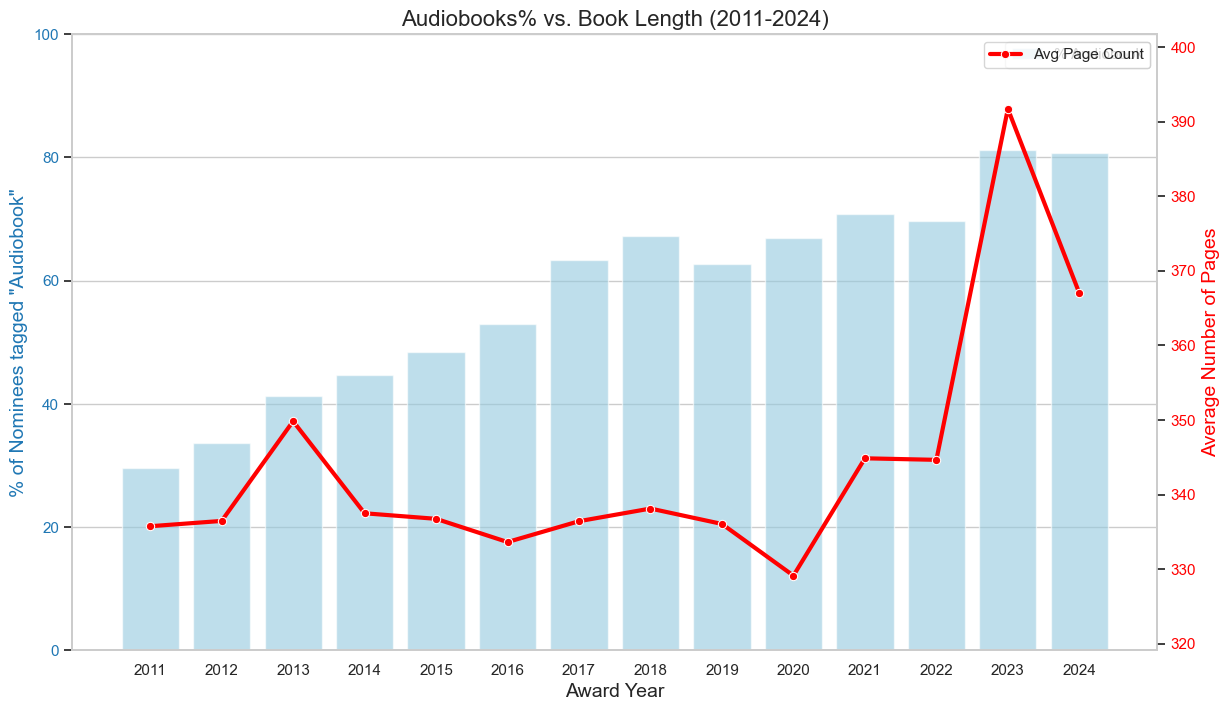

In [25]:
# ==========================================
# QUESTION 3 - PART B: Page Count vs. Audiobook Format (FIXED)
# ==========================================

# 1. Feature Engineering: Detect "Audiobook" format
# Ensure we handle potential missing values/types safely
df['is_audiobook'] = df['genres'].fillna('').apply(lambda x: 1 if 'Audiobook' in str(x) else 0)

# 2. Aggregation by Year
trends_df = df.groupby('award_year').agg({
    'num_pages': 'mean',          # Average length
    'is_audiobook': 'mean'        # Percentage of books
}).reset_index()

# Convert to percentage
trends_df['audio_pct'] = trends_df['is_audiobook'] * 100

# --- PRINT DATA FOR ANALYSIS ---
print("\n=== Yearly Trends Data: Pages vs Audiobooks ===")
# Display rounded for easier reading
display_table = trends_df.copy()
display_table['num_pages'] = display_table['num_pages'].round(1)
display_table['audio_pct'] = display_table['audio_pct'].round(1)
print(display_table)

print("-" * 50)
corr = trends_df['num_pages'].corr(trends_df['audio_pct'])
print(f"Correlation (Pearson) between Page Count and Audiobook %: {corr:.4f}")
print("-" * 50)

# 3. Visualization: Dual Axis Chart
fig, ax1 = plt.subplots(figsize=(14, 8))

# LAYER 1 (Bottom): Bars for Audiobook %
# We use ax1 for bars so they stay in the back
sns.barplot(
    x='award_year', 
    y='audio_pct', 
    data=trends_df, 
    color='skyblue', 
    alpha=0.6, 
    ax=ax1,
    label='% Audiobook'
)
ax1.set_ylabel('% of Nominees tagged "Audiobook"', color='tab:blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 100) # Percentage scale
ax1.set_xlabel('Award Year', fontsize=14)

# LAYER 2 (Top): Line for Page Count
# We use ax2 (twin) for the line so it sits on top
ax2 = ax1.twinx()

# Note: We map x to range(len) to ensure alignment with the categorical bars
sns.lineplot(
    x=range(len(trends_df)), 
    y='num_pages', 
    data=trends_df, 
    color='red', 
    marker='o', 
    linewidth=3, 
    ax=ax2,
    label='Avg Page Count'
)
ax2.set_ylabel('Average Number of Pages', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')
# Zoom in the Y-axis for pages to see the trend clearly (e.g., 320 to 400)
min_page = trends_df['num_pages'].min() - 10
max_page = trends_df['num_pages'].max() + 10
ax2.set_ylim(min_page, max_page)

plt.title('Audiobooks% vs. Book Length (2011-2024)', fontsize=16)
plt.grid(False) # Disable grid to avoid cluttering the dual axes

plt.show()


=== Audio vs. No Audio ===
-----------------------------------------------------------------
          Format  count          mean  median
No Audiobook Tag   2280  81146.665351 12610.5
Audiobook Tagged   3003 125606.173493 38841.0
-----------------------------------------------------------------
Insight: Audiobooks have 1.55x the average ratings of non-audiobooks.


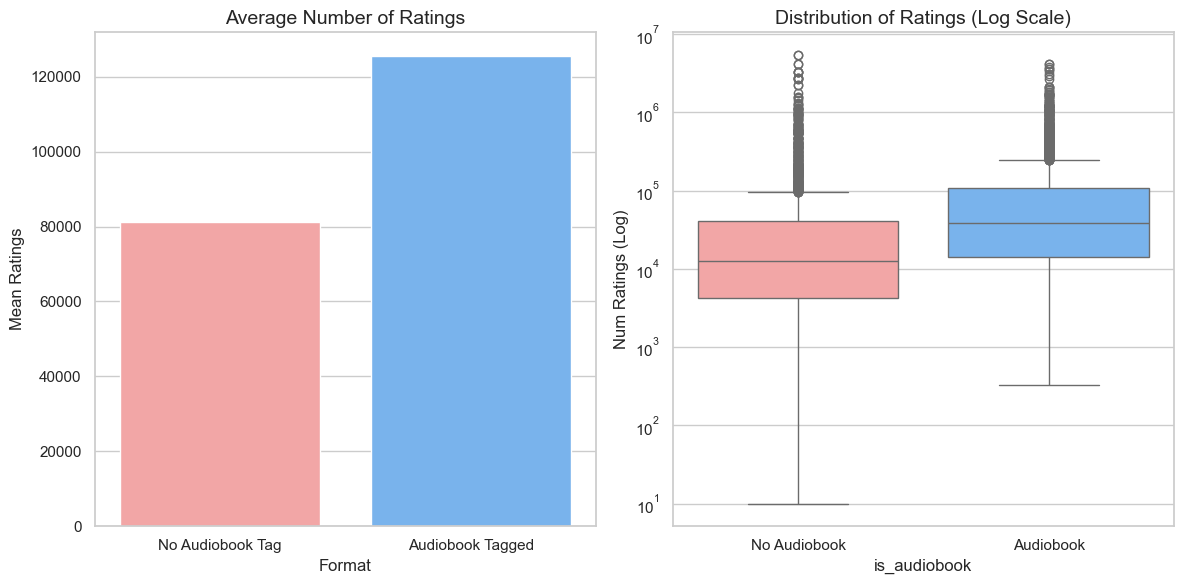

In [26]:
# ==========================================
# AUDIOBOOK VS. NON-AUDIOBOOK REACH ANALYSIS
# ==========================================

# 1. Group by the 'is_audiobook' flag and calculate stats
audio_comparison = df.groupby('is_audiobook')['num_ratings'].agg(['mean', 'median', 'count']).reset_index()

# 2. Map 0/1 to readable labels
audio_comparison['Format'] = audio_comparison['is_audiobook'].map({1: 'Audiobook Tagged', 0: 'No Audiobook Tag'})

# --- PRINT THE ANALYSIS TABLE ---
print("\n=== Audio vs. No Audio ===")
print("-" * 65)
# Formatting for readability
print(audio_comparison[['Format', 'count', 'mean', 'median']].to_string(index=False))
print("-" * 65)

# Calculate the Multiplier Effect
multiplier = audio_comparison.loc[1, 'mean'] / audio_comparison.loc[0, 'mean']
print(f"Insight: Audiobooks have {multiplier:.2f}x the average ratings of non-audiobooks.")

# 3. Visualization
plt.figure(figsize=(12, 6))

# A. Bar Plot for Averages
plt.subplot(1, 2, 1)
sns.barplot(x='Format', y='mean', data=audio_comparison, palette=['#ff9999','#66b3ff'], hue = 'Format', legend=False)
plt.title('Average Number of Ratings', fontsize=14)
plt.ylabel('Mean Ratings')

# B. Box Plot (Log Scale) to see the distribution spread
plt.subplot(1, 2, 2)
sns.boxplot(x='is_audiobook', y='num_ratings', data=df, palette=['#ff9999','#66b3ff'], hue = 'is_audiobook', legend=False)
plt.yscale('log') # Use log scale because max is 5 million
plt.title('Distribution of Ratings (Log Scale)', fontsize=14)
plt.xticks([0, 1], ['No Audiobook', 'Audiobook'])
plt.ylabel('Num Ratings (Log)')

plt.tight_layout()
plt.show()

In [27]:
from scipy import stats

# 1. Separate the two groups
group_audio = df[df['is_audiobook'] == 1]['num_ratings']
group_no_audio = df[df['is_audiobook'] == 0]['num_ratings']

# 2. Perform Welch's T-Test (Comparing Means)
# equal_var=False because the two groups likely have different standard deviations
t_stat, p_val_t = stats.ttest_ind(group_audio, group_no_audio, equal_var=False)

# 3. Perform Mann-Whitney U Test (Comparing Distributions/Medians)
# This is more reliable for your dataset because it's not affected by the 5-million-rating outliers
u_stat, p_val_u = stats.mannwhitneyu(group_audio, group_no_audio, alternative='greater')

print("=== Statistical Hypothesis Testing ===")
print("-" * 50)
print(f"Welch's T-test p-value:    {p_val_t:.4e}")
print(f"Mann-Whitney U p-value:    {p_val_u:.4e}")
print("-" * 50)

# 4. Interpret the result
if p_val_u < 0.05:
    print("Result: REJECT the Null Hypothesis (H0).")
    print("Conclusion: There is a statistically significant difference.")
    print("The 'is_audiobook' feature is a valid and powerful predictor for the model.")
else:
    print("Result: FAIL TO REJECT the Null Hypothesis.")
    print("The difference might be due to random chance.")

=== Statistical Hypothesis Testing ===
--------------------------------------------------
Welch's T-test p-value:    2.7304e-07
Mann-Whitney U p-value:    2.1035e-117
--------------------------------------------------
Result: REJECT the Null Hypothesis (H0).
Conclusion: There is a statistically significant difference.
The 'is_audiobook' feature is a valid and powerful predictor for the model.


### 2. Other genres

=== Top 20 Individual Genres by Average Reach ===


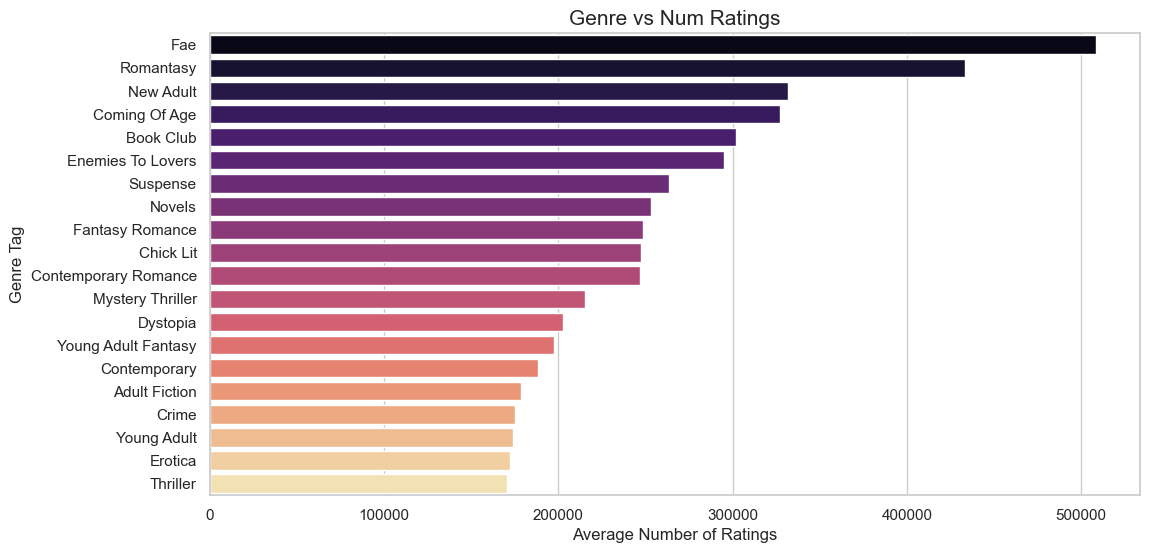

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

# 1. Prepare the List Format
# Ensure 'genres' is split into actual Python lists
df['genres_list'] = df['genres'].fillna('').str.split('|')

# ==========================================
# PART A: Individual Genre Reach (Top 20)
# ==========================================

# Explode the dataframe to have one row per genre per book
genre_exploded = df.explode('genres_list')

# Aggregate: Mean reach and count of occurrences
individual_genre_reach = genre_exploded.groupby('genres_list').agg(
    avg_reach=('num_ratings', 'mean'),
    book_count=('num_ratings', 'count')
).reset_index()

# Filter: We only care about genres with enough data (e.g., at least 50 books)
# to ensure the average isn't skewed by one single bestseller
significant_genres = individual_genre_reach[individual_genre_reach['book_count'] >= 50]
top_20_reach = significant_genres.sort_values(by='avg_reach', ascending=False).head(20)

print("=== Top 20 Individual Genres by Average Reach ===")

# Visualization
plt.figure(figsize=(12, 6))

# Fix: Assign y to hue and set legend=False
sns.barplot(
    x='avg_reach', 
    y='genres_list', 
    data=top_20_reach, 
    palette='magma', 
    hue='genres_list', 
    legend=False
)

plt.title('Genre vs Num Ratings', fontsize=15)
plt.xlabel('Average Number of Ratings')
plt.ylabel('Genre Tag')
plt.show()


=== Top Genre Combinations (Synergy) by Average Reach ===


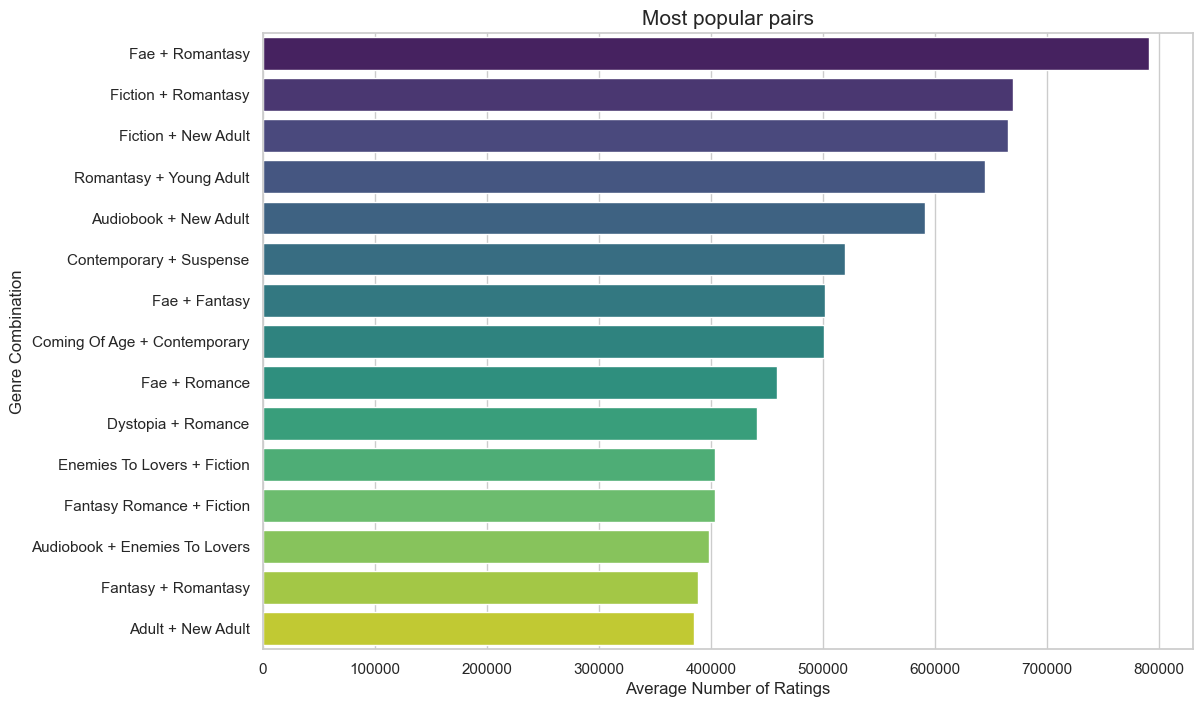

In [29]:
# ==========================================
# PART B: Genre Synergy (Combinations)
# ==========================================

# 1. Extract Pairs
# We will create a list of all genre pairs found in the dataset
all_pairs = []

for genre_list in df['genres_list']:
    if len(genre_list) > 1:
        # Sort them so (A, B) is same as (B, A)
        for pair in combinations(sorted(genre_list), 2):
            all_pairs.append(pair)

# 2. Find most common pairs to ensure statistical significance
pair_counts = Counter(all_pairs)
# We only analyze pairs that appear in at least 30 different nominated books
common_pairs = [pair for pair, count in pair_counts.items() if count >= 30]

# 3. Calculate reach for these specific pairs
pair_reach_data = []

for pair in common_pairs:
    # Filter books that contain BOTH genres
    mask = df['genres_list'].apply(lambda x: pair[0] in x and pair[1] in x)
    avg_reach = df[mask]['num_ratings'].mean()
    pair_reach_data.append({
        'Pair': f"{pair[0]} + {pair[1]}",
        'avg_reach': avg_reach,
        'count': pair_counts[pair]
    })

pair_reach_df = pd.DataFrame(pair_reach_data).sort_values(by='avg_reach', ascending=False)

print("\n=== Top Genre Combinations (Synergy) by Average Reach ===")

# Visualization
# Visualization
plt.figure(figsize=(12, 8))

# Fix: Assign 'Pair' to hue and set legend=False
sns.barplot(
    x='avg_reach', 
    y='Pair', 
    data=pair_reach_df.head(15), 
    palette='viridis', 
    hue='Pair', 
    legend=False
)

plt.title('Most popular pairs', fontsize=15)
plt.xlabel('Average Number of Ratings')
plt.ylabel('Genre Combination')
plt.show()


In [40]:
# ==========================================
# QUESTION 3 - PART C: Genre Publicity Analysis (Tables)
# ==========================================

# --- TABLE 1: Individual Genre Performance ---
print("\n" + "="*60)
print(f"{'Top 20 Individual Genres by Reach':^60}")
print("="*60)
print(f"{'Genre Name':<35} | {'Avg Reach':<12} | {'Sample'}")
print("-" * 60)

# Display top 20 significant individual genres
for _, row in top_20_reach.iterrows():
    name = row['genres_list']
    reach = row['avg_reach']
    count = row['book_count']
    print(f"{name:<35} | {reach:<12,.0f} | {count}")

print("-" * 60)


# --- TABLE 2: Genre Synergy (Combinations) ---
print("\n" + "="*60)
print(f"{'Top 15 Genre Combinations by Reach':^60}")
print("="*60)
print(f"{'Genre Pairing':<35} | {'Avg Reach':<12} | {'Sample'}")
print("-" * 60)

# Display top 15 significant pairings
for _, row in pair_reach_df.head(15).iterrows():
    pair = row['Pair']
    reach = row['avg_reach']
    count = row['count']
    print(f"{pair:<35} | {reach:<12,.0f} | {count}")

print("-" * 60)
print("Note: Minimum sample size of 50 for individuals and 30 for pairs.")


             Top 20 Individual Genres by Reach              
Genre Name                          | Avg Reach    | Sample
------------------------------------------------------------
Fae                                 | 508,320      | 54
Romantasy                           | 433,403      | 90
New Adult                           | 331,715      | 153
Coming Of Age                       | 327,134      | 59
Book Club                           | 302,130      | 71
Enemies To Lovers                   | 294,826      | 95
Suspense                            | 263,381      | 226
Novels                              | 252,824      | 68
Fantasy Romance                     | 248,306      | 65
Chick Lit                           | 247,444      | 209
Contemporary Romance                | 247,028      | 283
Mystery Thriller                    | 215,369      | 413
Dystopia                            | 202,724      | 223
Young Adult Fantasy                 | 197,583      | 131
Contemporary              

In [35]:
from scipy import stats

# 1. Define your groups based on your results
# Let's use the 'Fae + Romantasy' synergy as an example
genre_a = 'Fae'
genre_b = 'Romantasy'

# Group 1: Only Genre A (without B)
only_a = df[df['genres'].fillna('').str.contains(genre_a) & ~df['genres'].fillna('').str.contains(genre_b)]['num_ratings']

# Group 2: Only Genre B (without A)
only_b = df[df['genres'].fillna('').str.contains(genre_b) & ~df['genres'].fillna('').str.contains(genre_a)]['num_ratings']

# Group 3: Both (The Synergy)
both_ab = df[df['genres'].fillna('').str.contains(genre_a) & df['genres'].fillna('').str.contains(genre_b)]['num_ratings']

print(f"--- Synergy Validation: {genre_a} + {genre_b} ---")
print(f"Sample Sizes: {genre_a} only: {len(only_a)} | {genre_b} only: {len(only_b)} | Both: {len(both_ab)}")

# 2. Statistical Test (Kruskal-Wallis to see if any group is different)
h_stat, p_val_h = stats.kruskal(only_a, only_b, both_ab)
print(f"Kruskal-Wallis p-value: {p_val_h:.4e}")

# 3. Post-hoc: Is 'Both' significantly greater than 'Only A'?
u_stat, p_val_u = stats.mannwhitneyu(both_ab, only_a, alternative='greater')
print(f"Synergy vs. {genre_a} only p-value: {p_val_u:.4e}")

if p_val_u < 0.05:
    print(f"\nResult: REJECT H0. The combination of {genre_a} and {genre_b} is a statistically significant Force Multiplier.")
else:
    print("\nResult: FAIL TO REJECT H0. The synergy might be driven by outliers.")

--- Synergy Validation: Fae + Romantasy ---
Sample Sizes: Fae only: 24 | Romantasy only: 60 | Both: 30
Kruskal-Wallis p-value: 2.6441e-03
Synergy vs. Fae only p-value: 7.9017e-04

Result: REJECT H0. The combination of Fae and Romantasy is a statistically significant Force Multiplier.


## Question 4: Can we predict a book's num rating based on its metadata and author reputation?

In [30]:
# ==========================================
# 3. FEATURE CLASSIFICATION (Refined)
# ==========================================

# Configuration
DISCRETE_THRESHOLD = 25 
TARGET_COL = 'num_ratings'

# Columns to explicitly ignore/drop:
COLS_TO_IGNORE = [
    'is_audiobook', 'author', 'title', 'category', 'award_year',
    'votes', 'num_reviews',
    'five_star_count', 'five_star_percentage',
    'four_star_count', 'four_star_percentage',
    'three_star_count', 'three_star_percentage',
    'two_star_count', 'two_star_percentage',
    'one_star_count', 'one_star_percentage', 
]

COLS_TO_AVOID = ['genres_list', 'binned']

col_info = {}
target_features = []
categorical_features = [] 
numerical_discrete_features = []
numerical_continuous_features = []
ignored_features = [] 

# Loop through columns to detect type
for col_name in df.columns:
    if col_name in COLS_TO_AVOID:
        continue

    unique_count = df[col_name].nunique()
    
    if col_name in COLS_TO_IGNORE:
        col_type = "Ignored"
        ignored_features.append(col_name)

    elif col_name == TARGET_COL:
        col_type = "Target"
        target_features.append(col_name)
    
    elif pd.api.types.is_numeric_dtype(df[col_name]):
        col_type = "Numerical"
        if unique_count < DISCRETE_THRESHOLD:
            numerical_discrete_features.append(col_name)
        else:
            numerical_continuous_features.append(col_name)
            
    else:
        col_type = "Categorical"
        categorical_features.append(col_name)

    col_info[col_name] = {"Type": col_type, "UniqueCount": unique_count}

print("-" * 60)
print(f"{'Column Name':<30} | {'Type':<12} | {'Unique Vals'}")
print("-" * 60)

# Group 0: Target
for col in target_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

# Group 1: Categorical
for col in categorical_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

# Group 2: Numerical 
for col in numerical_discrete_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

for col in numerical_continuous_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

# Group 3: Ignored
for col in ignored_features:
    if col in col_info:
        info = col_info[col]
        print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

print("\nSummary:")
print(f"Target Variable:        {target_features}")
print(f"Categorical Features:   {len(categorical_features)}")
print(f"Numerical Discrete:     {len(numerical_discrete_features)}")
print(f"Numerical Continuous:   {len(numerical_continuous_features)}")
print(f"Ignored Features:       {len(ignored_features)}")

------------------------------------------------------------
Column Name                    | Type         | Unique Vals
------------------------------------------------------------
num_ratings                    | Target       | 4956
------------------------------------------------------------
genres                         | Categorical  | 4724
------------------------------------------------------------
publication_year               | Numerical    | 23
price                          | Numerical    | 141
rating                         | Numerical    | 155
num_pages                      | Numerical    | 668
author_book_count              | Numerical    | 343
author_followers_count         | Numerical    | 2085
------------------------------------------------------------
title                          | Ignored      | 5036
num_reviews                    | Ignored      | 3952
author                         | Ignored      | 3106
five_star_count                | Ignored      | 4644
five_


--- Distribution of Target: num_ratings ---


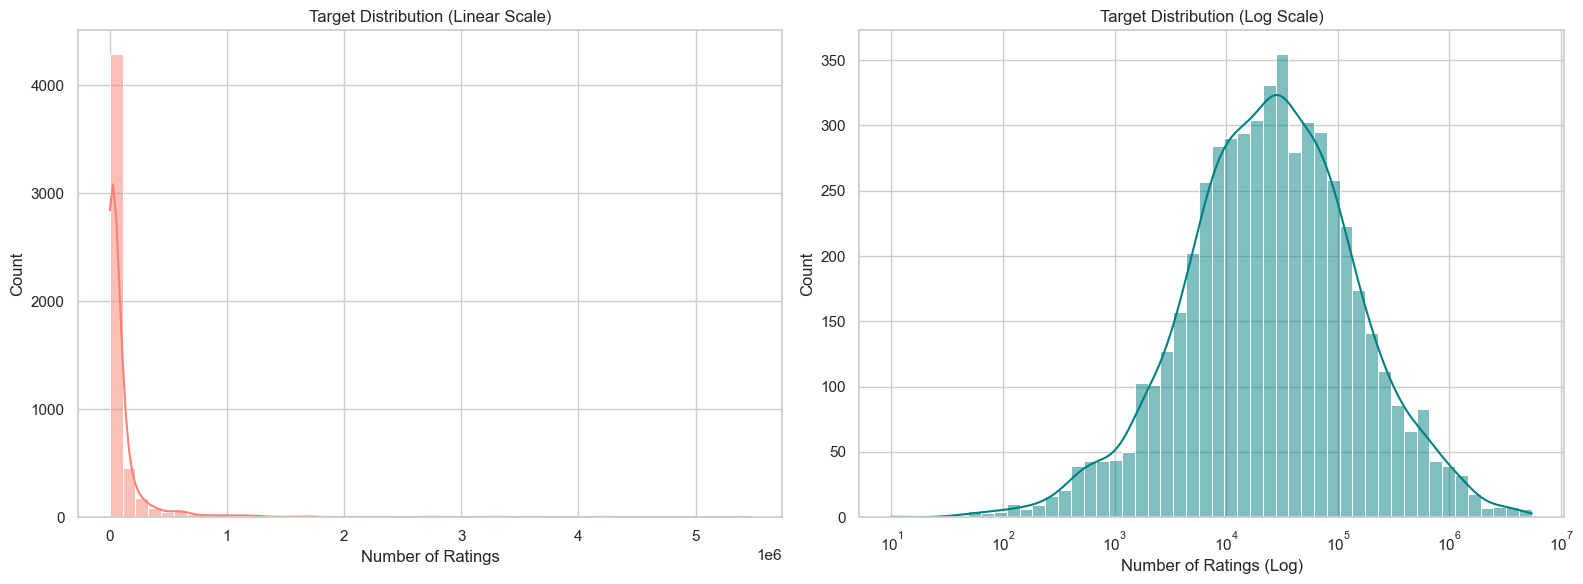

In [31]:
print(f"\n--- Distribution of Target: {TARGET_COL} ---")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df[TARGET_COL], bins=50, kde=True, ax=axes[0], color='salmon')
axes[0].set_title(f"Target Distribution (Linear Scale)")
axes[0].set_xlabel("Number of Ratings")

sns.histplot(df[TARGET_COL], bins=50, kde=True, ax=axes[1], color='teal', log_scale=True)
axes[1].set_title(f"Target Distribution (Log Scale)")
axes[1].set_xlabel("Number of Ratings (Log)")

plt.tight_layout()
plt.show()


--- Numerical Feature Distributions and Outliers (6 features) ---


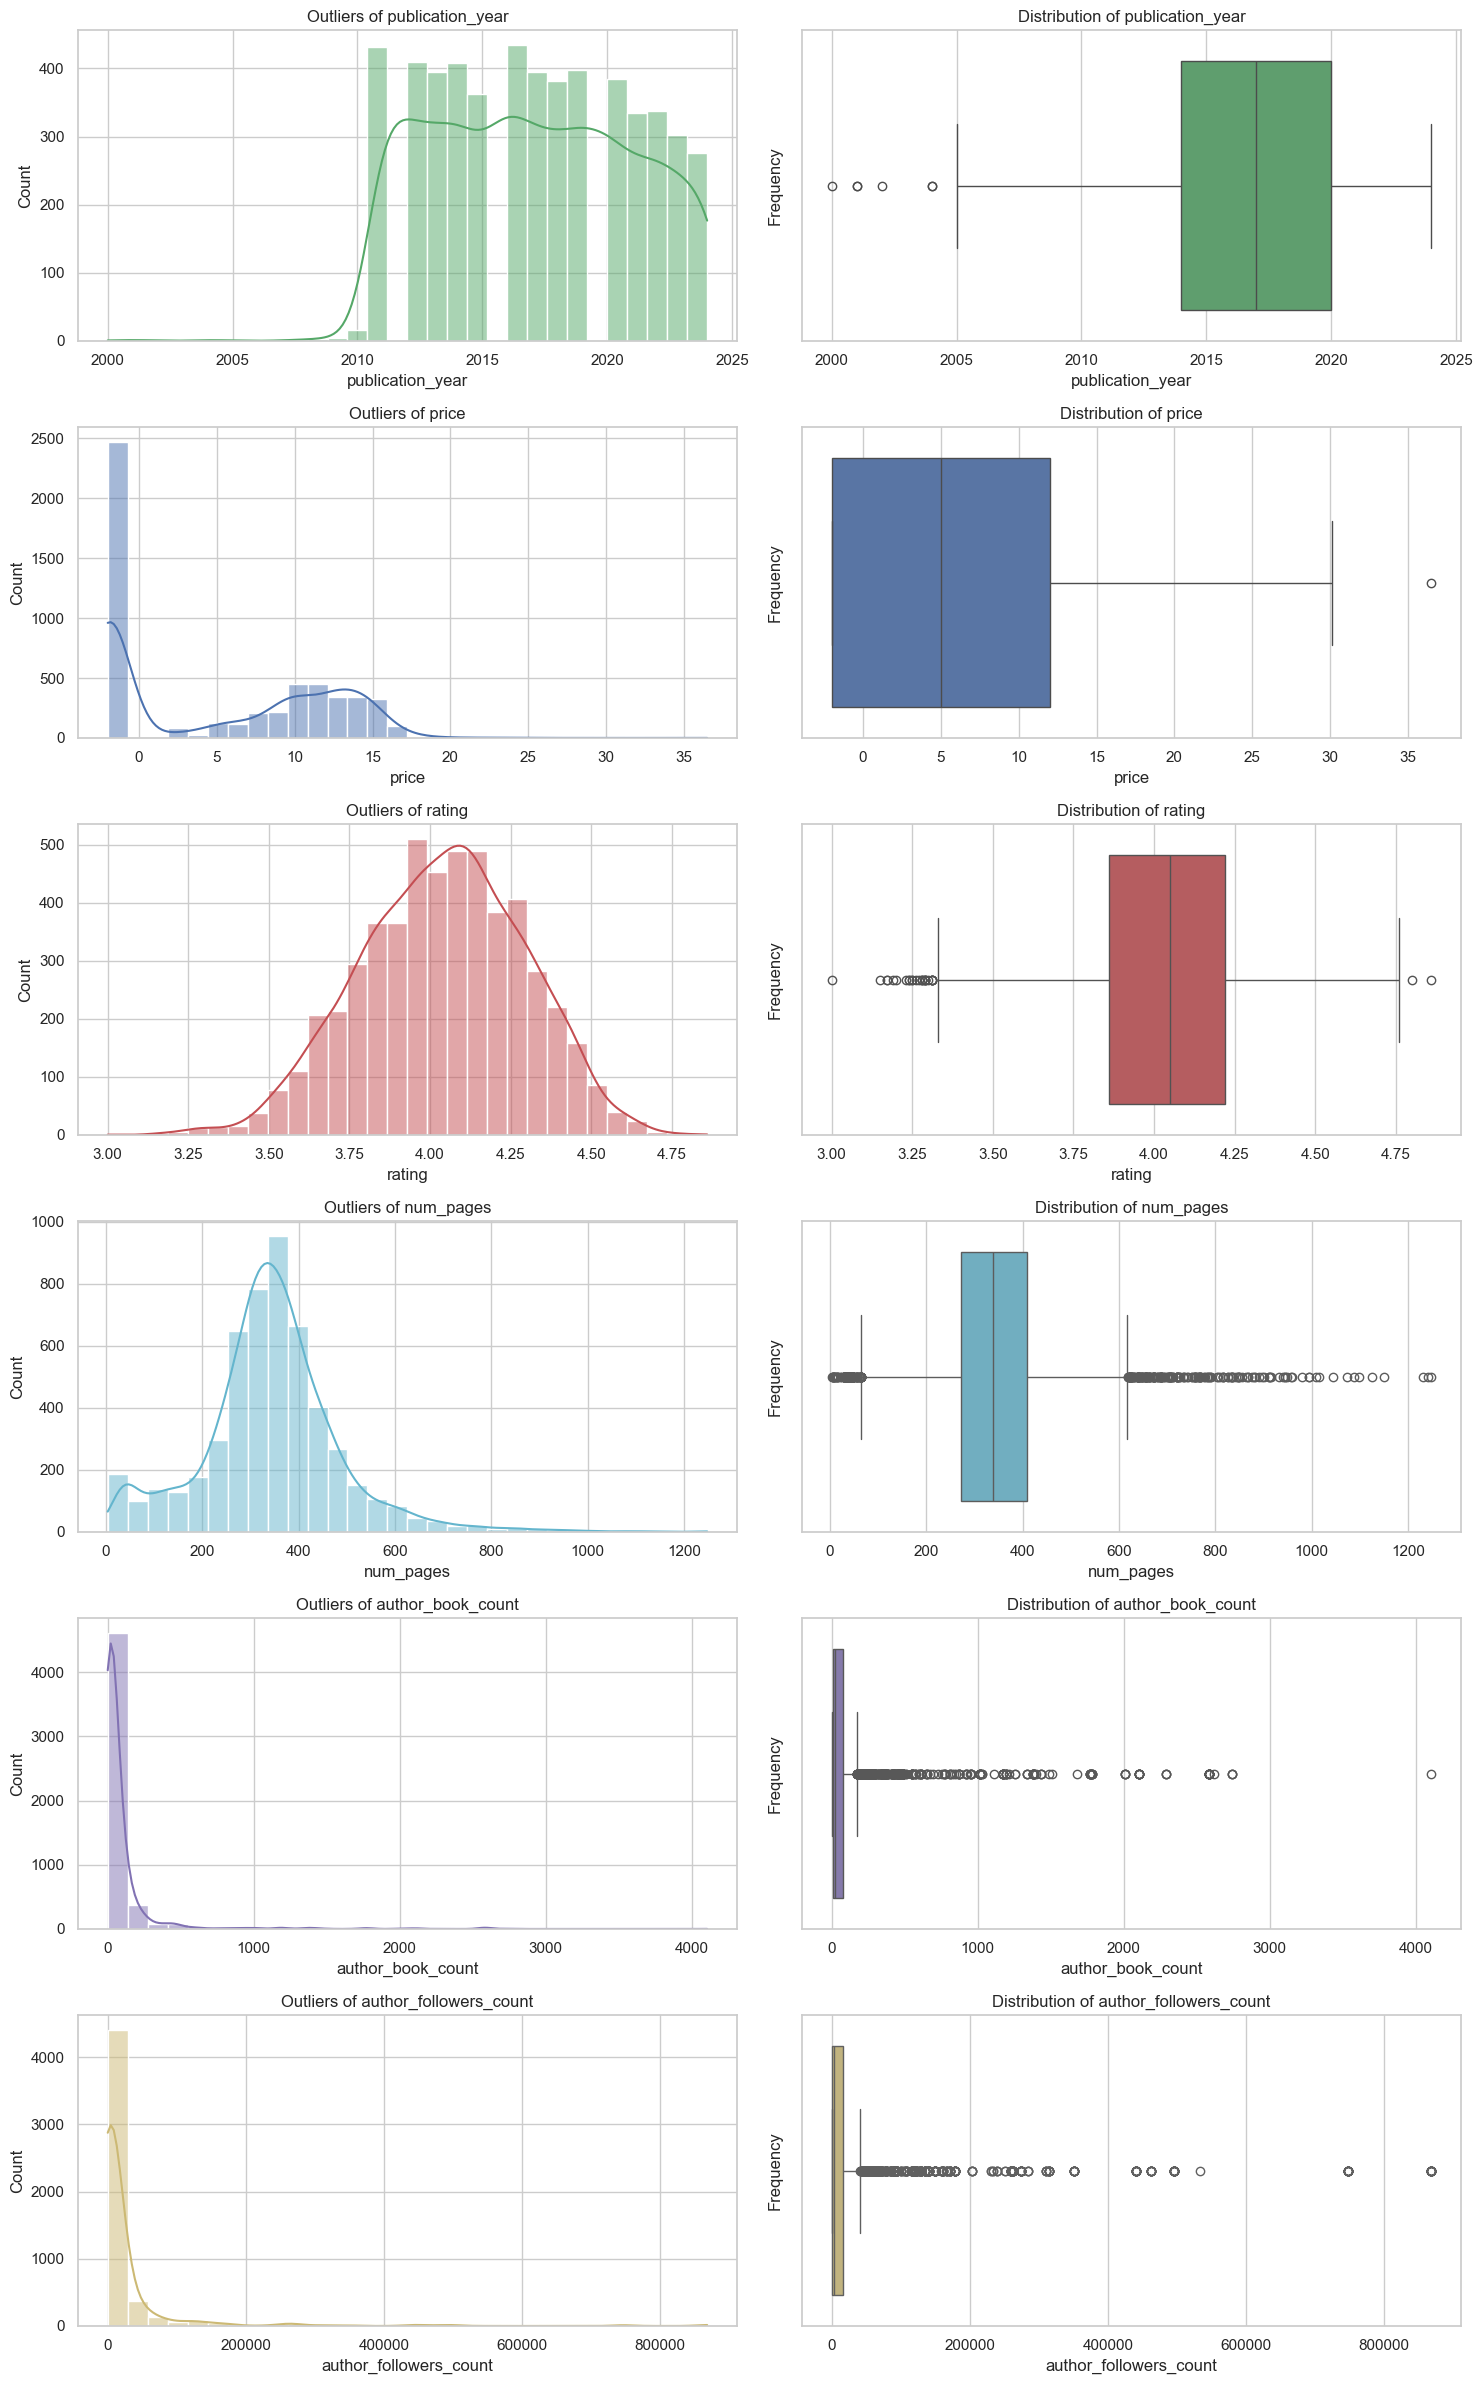

In [32]:
# ==========================================
# 6. NUMERICAL FEATURE DISTRIBUTIONS
# ==========================================
# Features identified from the classification table
numerical_to_plot = [
    'publication_year', 
    'price', 
    'num_pages', 
    'author_book_count', 
    'author_followers_count'
]

# ==========================================
# 6. NUMERICAL FEATURE DISTRIBUTIONS & OUTLIERS
# ==========================================

# 1. Identify numerical features
numerical_features = [
    'publication_year', 
    'price', 
    'rating',
    'num_pages', 
    'author_book_count', 
    'author_followers_count'
]

num_features = len(numerical_features)
colors = ['g', 'b', 'r', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']

# 2. Create subplots: 1 row per feature, 2 columns (Boxplot | Histogram)
print(f"\n--- Numerical Feature Distributions and Outliers ({num_features} features) ---")
fig, axes = plt.subplots(num_features, 2, figsize=(15, 4 * num_features))

for idx, col in enumerate(numerical_features):
    # Select color for this row
    current_color = colors[idx % len(colors)]
    
    # Left Side: Box Plot (Outlier Visualization)
    sns.boxplot(x=df[col], color=current_color, ax=axes[idx, 1])
    axes[idx, 0].set_title(f'Outliers of {col}', fontsize=12)
    axes[idx, 0].set_xlabel('')
    
    # Right Side: Histogram (Distribution Visualization)
    sns.histplot(df[col], bins=30, kde=True, color=current_color, ax=axes[idx, 0])
    axes[idx, 1].set_title(f'Distribution of {col}', fontsize=12)
    axes[idx, 1].set_xlabel(col)
    axes[idx, 1].set_ylabel('Frequency')

# 3. Final polish
plt.tight_layout()
plt.show()


--- Numerical Features vs Target: num_ratings ---


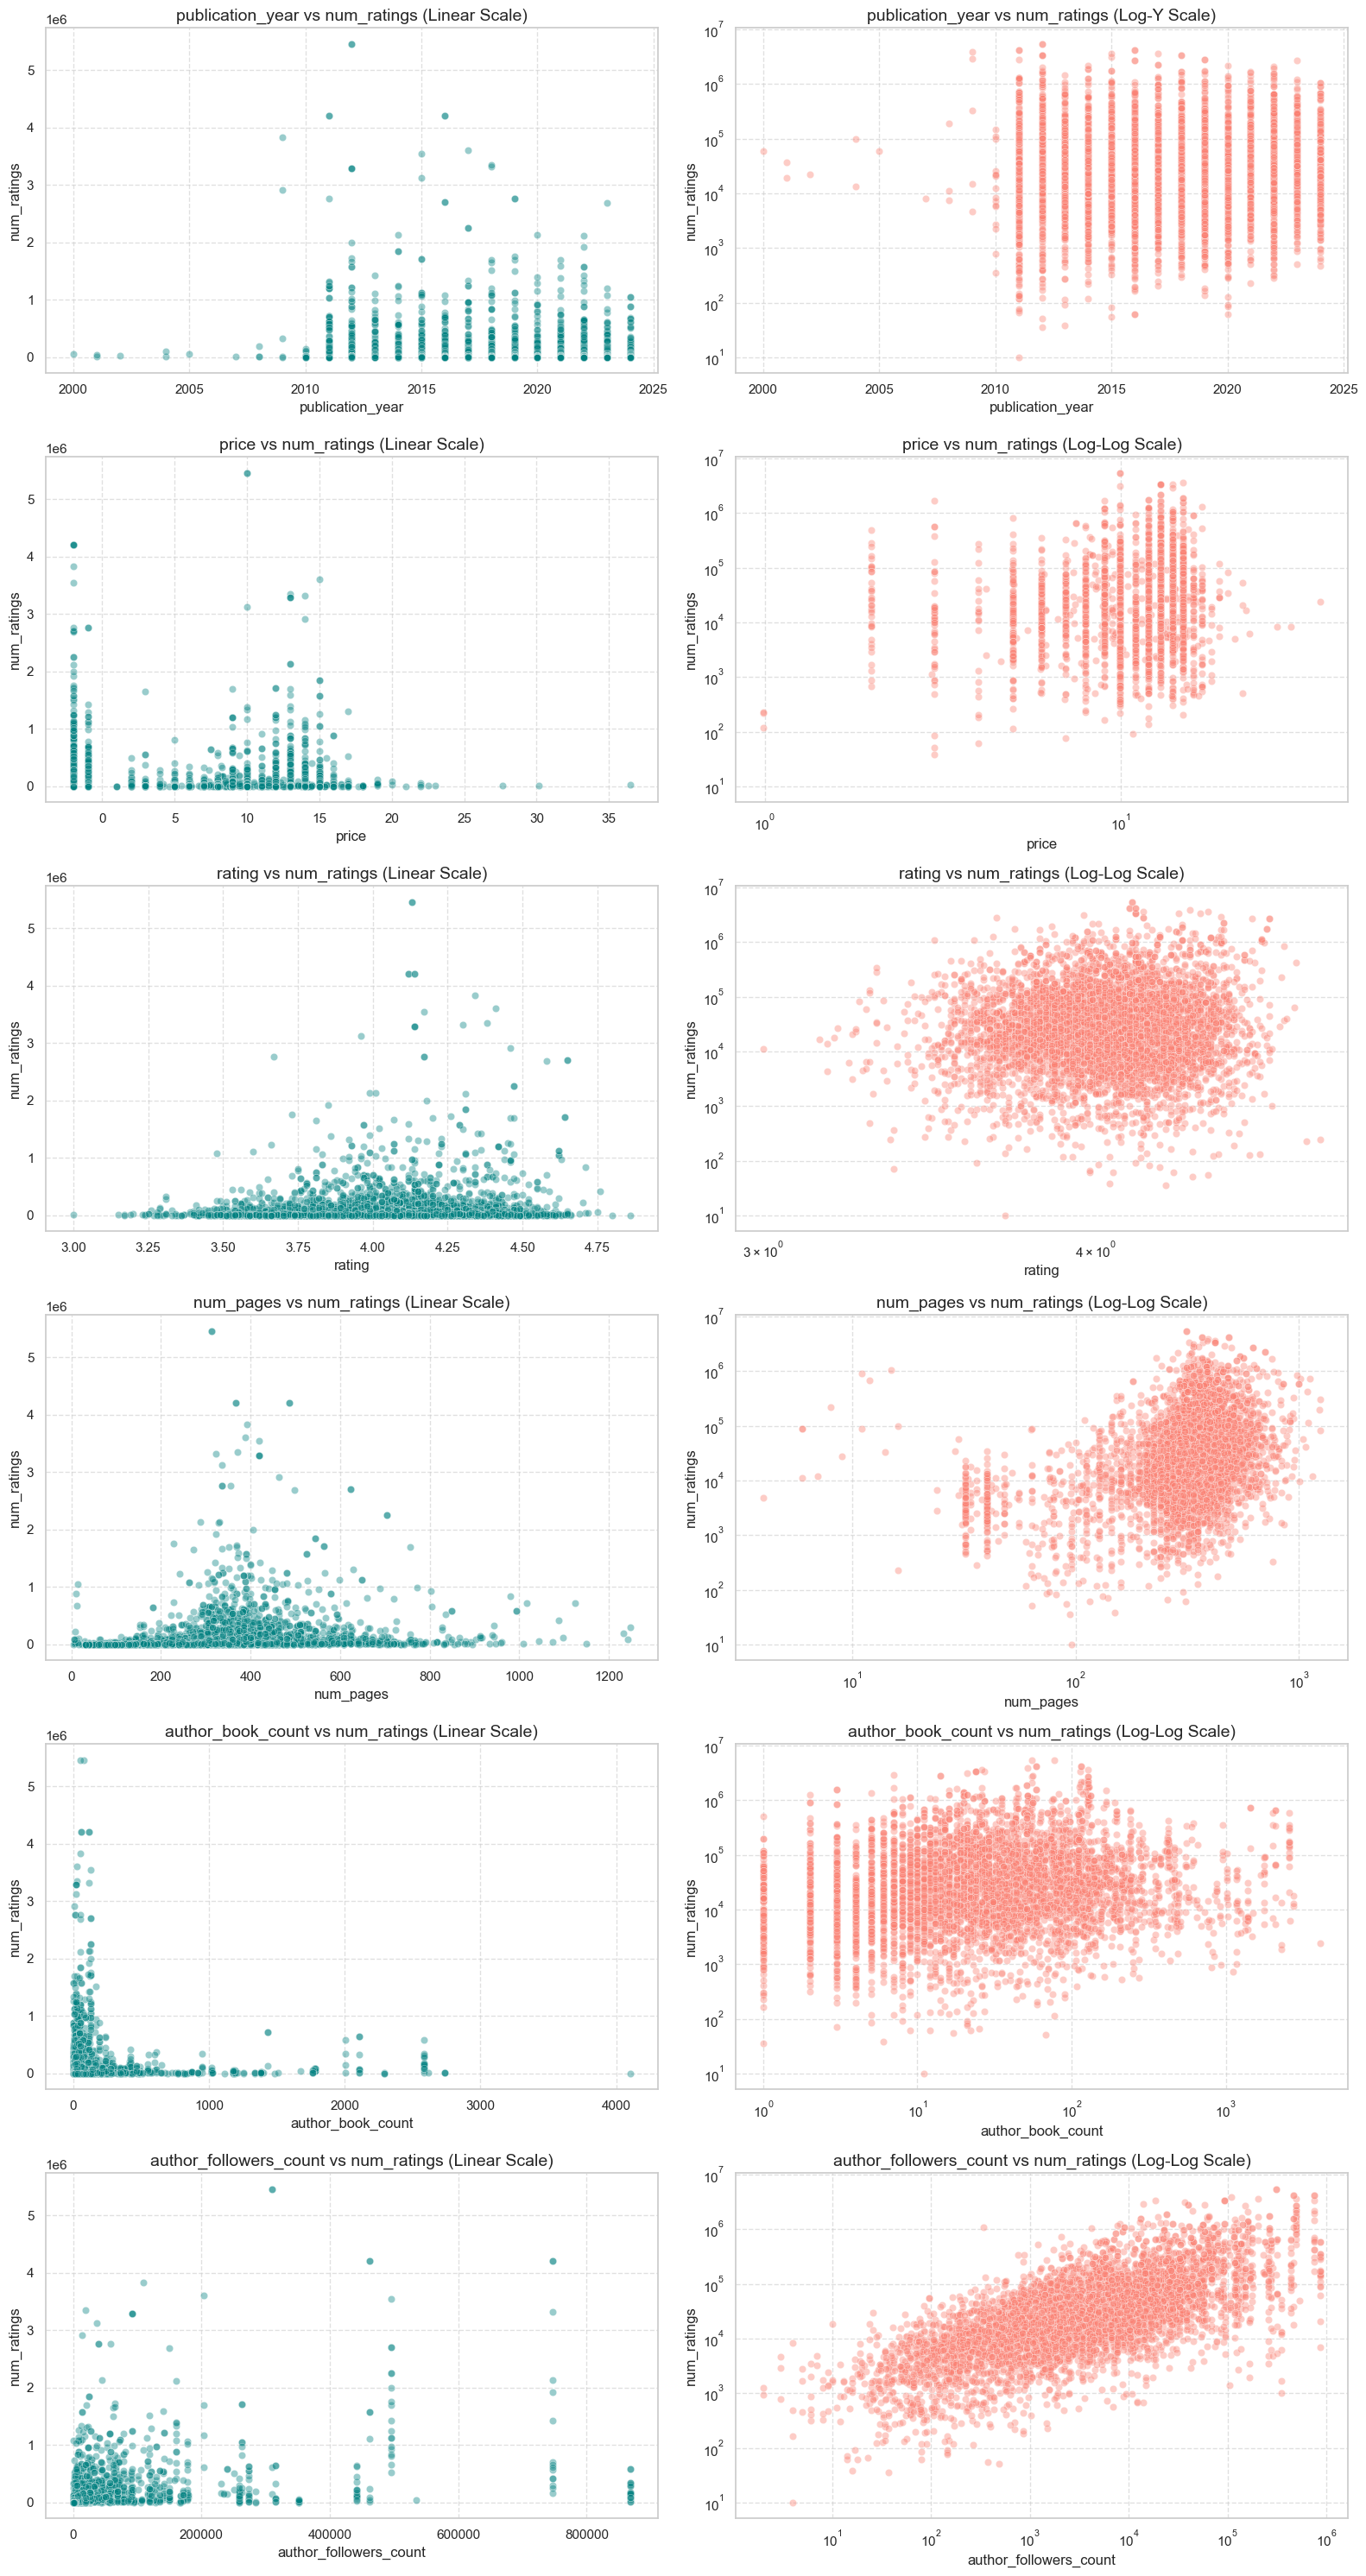

In [33]:
# ==========================================
# 7. NUMERICAL FEATURES vs TARGET (num_ratings)
# ==========================================
print(f"\n--- Numerical Features vs Target: {TARGET_COL} ---")

numerical_to_plot = [
    'publication_year', 
    'price', 
    'rating',
    'num_pages', 
    'author_book_count', 
    'author_followers_count'
]

n_rows = len(numerical_to_plot)
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5 * n_rows))

for idx, col in enumerate(numerical_to_plot):
    # Filter data to remove NaNs for the specific pair
    plot_df = df[[col, TARGET_COL]].dropna()
    
    # 1. Standard Scatter Plot (Linear Scale)
    sns.scatterplot(data=plot_df, x=col, y=TARGET_COL, alpha=0.4, color='teal', ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{col} vs {TARGET_COL} (Linear Scale)', fontsize=14)
    axes[idx, 0].grid(True, linestyle='--', alpha=0.6)
    
    # 2. Log-Log Scatter Plot (Reveals power-law relationships)
    # Using log_scale=True for both axes where appropriate
    is_log_x = True if col != 'publication_year' else False # Year shouldn't be logged
    
    sns.scatterplot(data=plot_df, x=col, y=TARGET_COL, alpha=0.4, color='salmon', ax=axes[idx, 1])
    axes[idx, 1].set_yscale('log')
    if is_log_x:
        axes[idx, 1].set_xscale('log')
        axes[idx, 1].set_title(f'{col} vs {TARGET_COL} (Log-Log Scale)', fontsize=14)
    else:
        axes[idx, 1].set_title(f'{col} vs {TARGET_COL} (Log-Y Scale)', fontsize=14)
        
    axes[idx, 1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


--- Correlation Matrix (Numerical Features & Target) ---


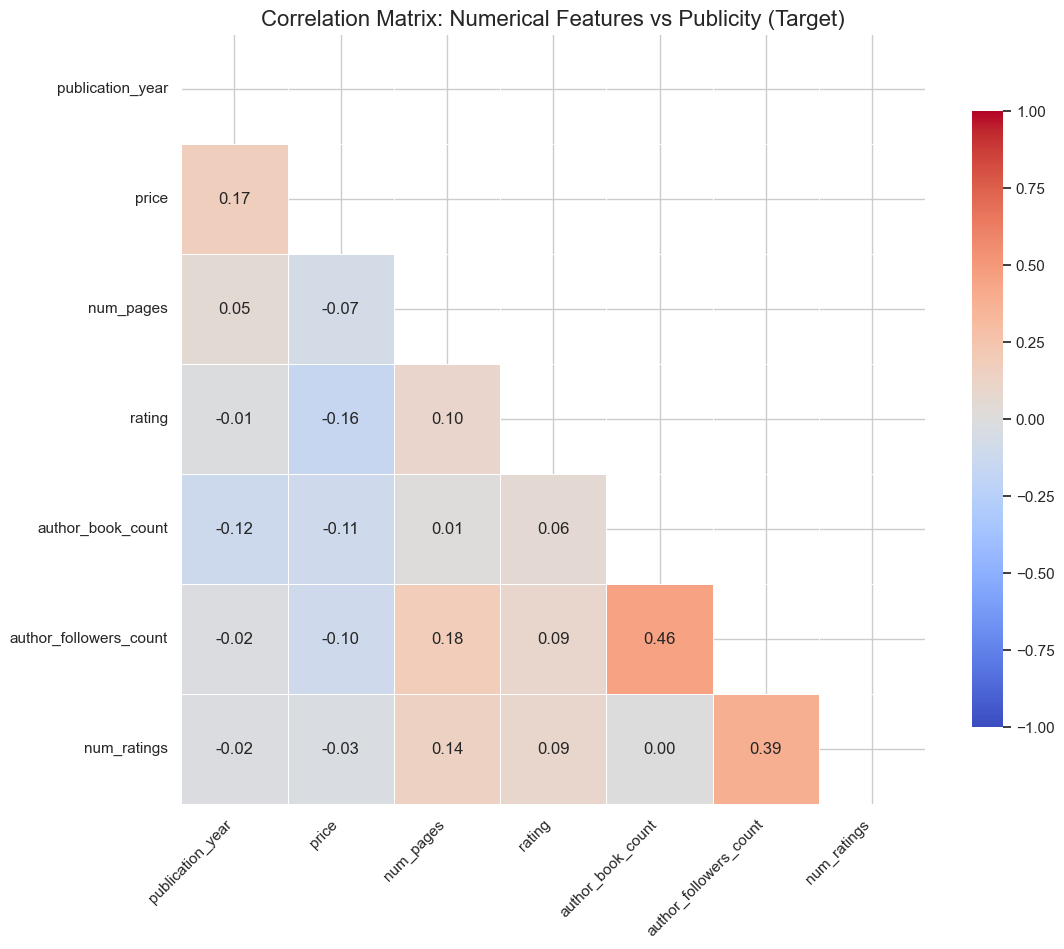

In [34]:
# ==========================================
# 8. CORRELATION ANALYSIS (Features + Target)
# ==========================================
print(f"\n--- Correlation Matrix (Numerical Features & Target) ---")

# 1. Select the relevant features and the target
correlation_cols = [
    'publication_year', 
    'price', 
    'num_pages', 
    'rating',
    'author_book_count', 
    'author_followers_count',
    'num_ratings'
]

# 2. Calculate the correlation matrix
# We dropna() to ensure correlations are calculated only on valid pairs
corr_matrix = df[correlation_cols].corr()

# 3. Create a mask for the upper triangle
# This makes the heatmap much easier to read by removing redundant data
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 4. Plot the Heatmap
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix, 
    mask=mask,          # Apply the triangle mask
    annot=True,         # Show the correlation numbers
    fmt=".2f",          # 2 decimal places
    cmap='coolwarm',    # Red for positive, Blue for negative
    vmin=-1, vmax=1,    # Standard correlation scale
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title('Correlation Matrix: Numerical Features vs Publicity (Target)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

### Modelling plan:

#### 1. Preprocessing:
*   Remove rows with missing values, drop leakage columns
*   Pricing: encode pricing (bundle, subscription and normal pricing)
*   Author reputation: Encode author popularity
*   Genre: one-hot-encode popular genres and combination of genres
*   Perform log transformation, normalization.
*   Split into Train and Test datasets
#### 2. Modelling
*   Train model (linear regression, random forest)
*   Fine tune models
*   Perform evaluation and comparison